In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import argparse
import itertools
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.metrics import confusion_matrix

In [3]:
pd.options.display.max_rows = 999

In [10]:
def get_confusion_matrix(json_files, is_fine=False, all_label_sets_ordered=None):
    results_dicts = []
    for json_file in json_files:
        with open(json_file, 'r') as json_data:
            results_dicts.append(json.load(json_data))
    json_gold_pred = "label_set_info (id/gold/pred)"
    json_gold_pred_fine = "id_gold_pred_fine"
    json_cm = 'confusion_matrix'
    if is_fine:
        json_gold_pred = json_gold_pred_fine
        json_cm += '_fine'
    id_gold_preds = []
    binary_confusion_matrix = np.zeros((6,2,2))
    for results_dict in results_dicts:
        id_gold_preds_folds.append(results_dict[json_gold_pred])
        binary_confusion_matrix += np.array(results_dict[json_cm])
    
    n_rows = 3
    n_cols = 2
    n_classes = 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    row_idx, col_idx = 0, 0
    for idx, cm in enumerate(binary_confusion_matrix):
        ax = axes[row_idx, col_idx]
        ax.set_title(class_labels[idx])
        #ax.set_ylabel('True')
        #ax.set_xlabel('Predicted')
        ax.imshow(cm, interpolation='nearest', cmap='Wistia')
        s = [['TN','FP'], ['FN', 'TP']]
        for i in range(2):
            for j in range(2):
                #ax.text(j,i, str(s[i][j])+"="+str(cm[i][j]))
                ax.text(j,i, str(cm[i][j])+"("+str((cm[i][j]/np.array(cm).sum(axis=1)*100)[i])[:4]+"%)")
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=[0,1],
               yticklabels=[0,1],
               ylabel="True label",
               xlabel="Predicted label")
        ax.grid(False)
        ax.set_ylim((n_classes - 0.5, -0.5))
        #plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
        # increment counters
        col_idx += 1
        if col_idx >= n_cols:
            col_idx = 0
            row_idx += 1
    fig.tight_layout()
    plt.show()
    doc_ids = []
    target_labels = []
    predicted_labels = []
    target_coarse_labels=[]
    predicted_coarse_labels=[]
    target_sets = []
    predicted_sets = []
    print(len(id_gold_preds_folds))
    for id_gold_preds_fold in id_gold_preds_folds:
        print('id_gold_pred', id_gold_pred)
        doc_fold_ids = []
        target_fold_labels = []
        predicted_fold_labels = []
        target_coarse_fold_labels = []
        pred_coarse_fold_labels = []
        for doc_id, gold_set, pred_set in id_gold_pred:
            coarse_gold = []
            coarse_pred = []
            if gold_set[0] or gold_set[1]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
            if gold_set[2] or gold_set[3]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
            if gold_set[4] or gold_set[5]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
                
            if pred_set[0] or pred_set[1]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            if pred_set[2] or pred_set[3]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            if pred_set[4] or pred_set[5]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            
            target_fold_labels.append(gold_set)
            predicted_fold_labels.append(pred_set)
            target_coarse_fold_labels.append(coarse_gold)
            pred_coarse_fold_labels.append(coarse_pred)
            target_sets.append(gold_set)
            predicted_sets.append(pred_set)
            
            doc_fold_ids.append([doc_id]*len(gold_set))
        target_labels.append(target_fold_labels)
        predicted_labels.append(predicted_fold_labels)
        
        target_coarse_labels.append(target_coarse_fold_labels)
        predicted_coarse_labels.append(pred_coarse_fold_labels)
        
        doc_ids.append(doc_fold_ids)
        
    target_sets = [''.join(map(str, target_label_set)) for target_label_set in target_sets]
    predicted_sets = [''.join(map(str, predicted_label_set)) for predicted_label_set in predicted_sets]
    
    if all_label_sets_ordered is None:
        s = pd.Series(target_sets)
        s.value_counts().plot(kind='bar')
        target_sets_ordered = s.value_counts().index.values
    
        missing_labels = set(predicted_sets).difference(set(target_sets_ordered))
        all_label_sets_ordered = np.append(target_sets_ordered,list(missing_labels))
    cm=confusion_matrix(target_sets, predicted_sets, labels=all_label_sets_ordered)
    
    plot_confusion_matrix(cm, all_label_sets_ordered, normalize=False)
    plt.show()
    return doc_ids, target_labels, predicted_labels, target_coarse_labels, predicted_coarse_labels, all_label_sets_ordered

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text_color = "black"
        if i==j:
            text_color = "red"
        elif cm[i, j] > thresh:
            text_color = "white"
                
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color=text_color)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color=text_color)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

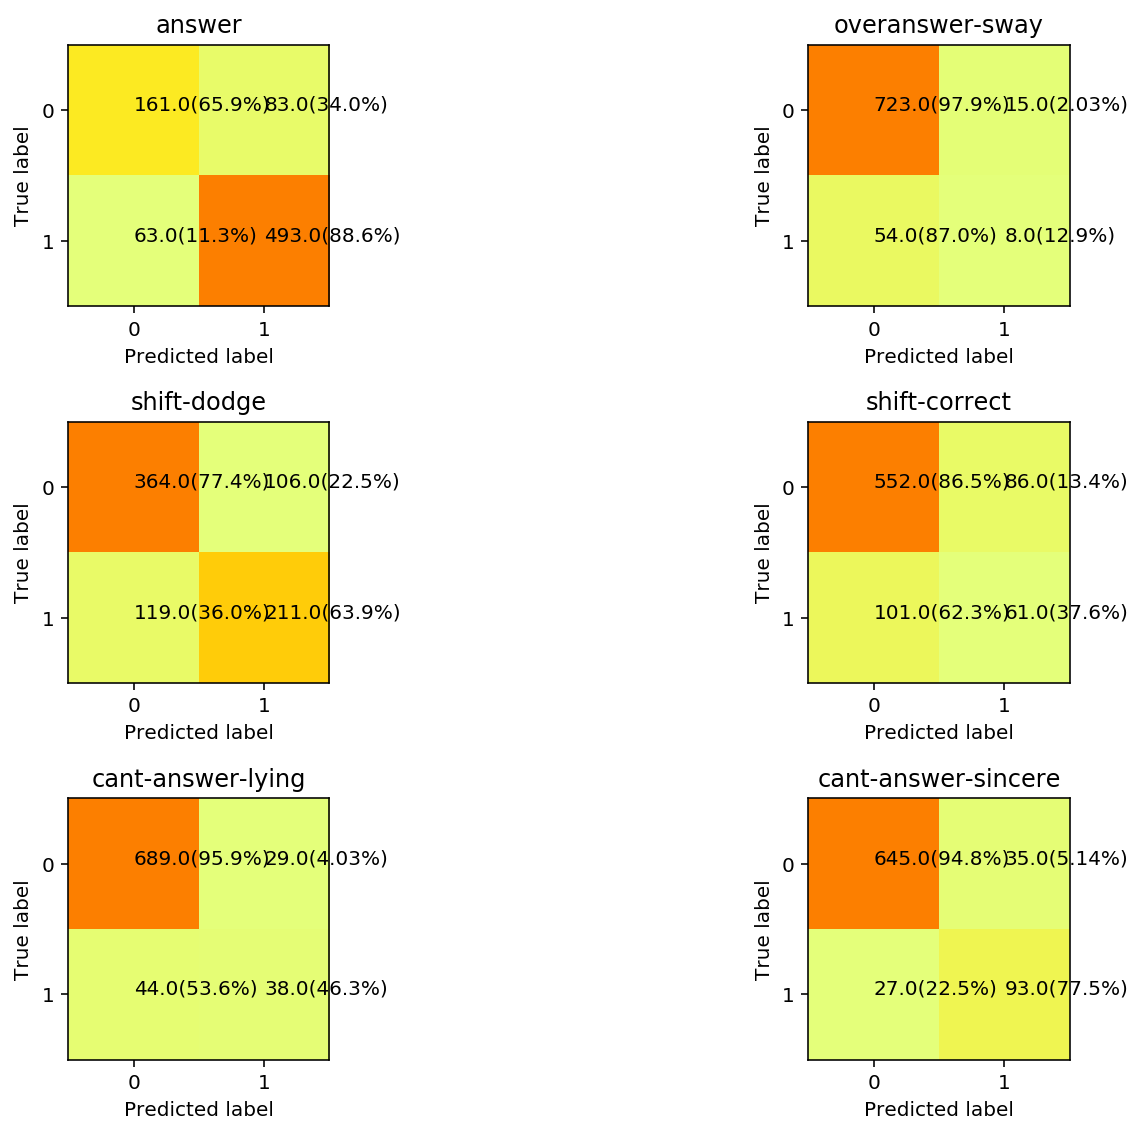

4
id_gold_pred [[11637282057, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504011, [0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11531504140, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504035, [0, 0, 1, 0, 0, 0], [1, 0, 1, 1, 0, 0]], [11637282124, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282130, [0, 0, 1, 1, 0, 0], [0, 0, 1, 1, 0, 0]], [11531504113, [1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11531504102, [1, 0, 0, 1, 0, 1], [1, 0, 1, 0, 0, 0]], [11422125049, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125006, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1]], [11637282014, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0]], [11422125138, [1, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1]], [11531504072, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11531504138, [0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0]], [11636001100, [0, 0, 0, 0, 1, 1], [0, 0, 1, 1, 0, 1]], [11531504007, [1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 0]], [11636001030, [0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1]], [11637282018, [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0,

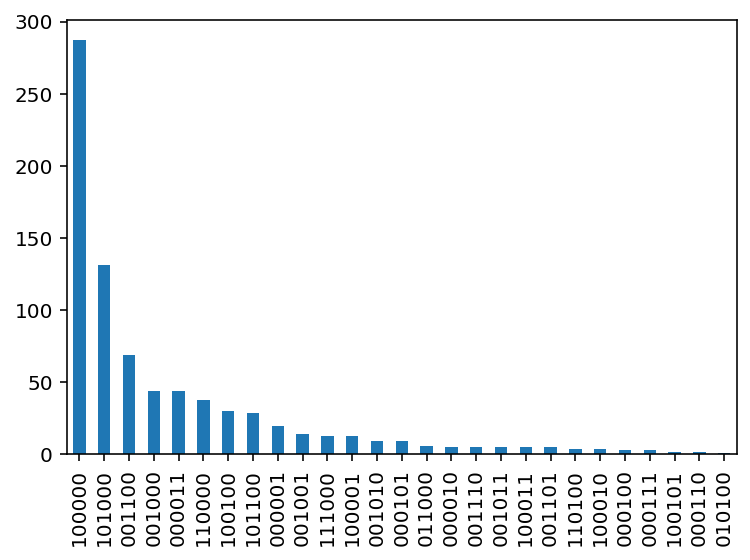

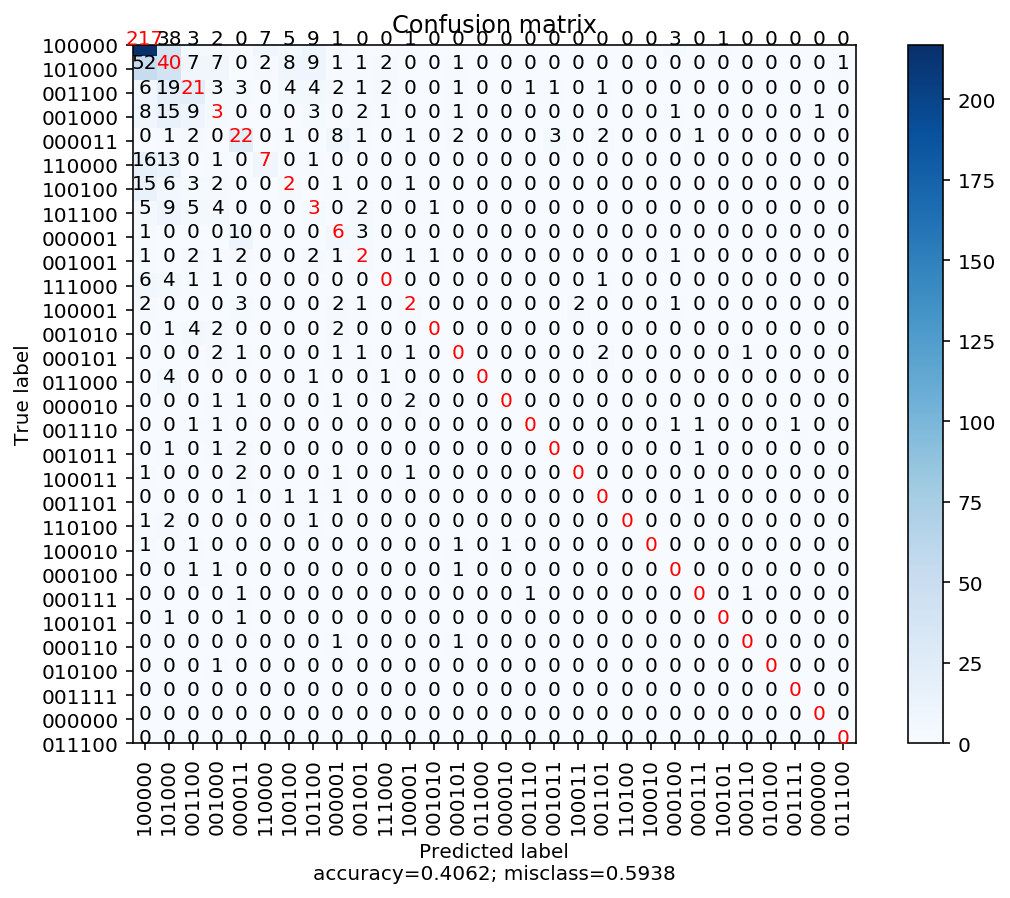

In [11]:
class_labels = ['answer', 'overanswer-sway', 
                'shift-dodge', 'shift-correct', 
                'cant-answer-lying','cant-answer-sincere']
base_files = []
for fold_num in range(4):
    base_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_classification/1_input/metrics_roberta_classification_r_text_test.json_fold'+str(fold_num)+'_test')
base_ids, base_targets, base_preds, base_coarse_targets, base_coarse_preds, base_targets_ordered = get_confusion_matrix(base_files)

In [7]:
base_ids

[[[11637282057,
   11637282057,
   11637282057,
   11637282057,
   11637282057,
   11637282057],
  [11531504011,
   11531504011,
   11531504011,
   11531504011,
   11531504011,
   11531504011],
  [11531504140,
   11531504140,
   11531504140,
   11531504140,
   11531504140,
   11531504140],
  [11531504035,
   11531504035,
   11531504035,
   11531504035,
   11531504035,
   11531504035],
  [11637282124,
   11637282124,
   11637282124,
   11637282124,
   11637282124,
   11637282124],
  [11637282130,
   11637282130,
   11637282130,
   11637282130,
   11637282130,
   11637282130],
  [11531504113,
   11531504113,
   11531504113,
   11531504113,
   11531504113,
   11531504113],
  [11531504102,
   11531504102,
   11531504102,
   11531504102,
   11531504102,
   11531504102],
  [11422125049,
   11422125049,
   11422125049,
   11422125049,
   11422125049,
   11422125049],
  [11422125006,
   11422125006,
   11422125006,
   11422125006,
   11422125006,
   11422125006],
  [11637282014,
   11637282014

In [ ]:
all_class_labels = []
all_base_ids = []
all_base_targets = []
all_base_preds = []
for fold in range(len(base_ids)):
    all_class_labels.append(class_labels*(len(base_ids[fold])))
    all_base_ids.append(list(itertools.chain.from_iterable(base_ids[fold])))
    all_base_targets.append(list(itertools.chain.from_iterable(base_targets[fold])))
    all_base_preds.append(list(itertools.chain.from_iterable(base_preds[fold])))
base_dfs=[]
for fold in range(len(base_ids)):
    base_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_base_ids[fold], all_base_targets[fold], all_base_preds[fold]), columns=['label','qa_index','gold','pred']))
    base_dfs[fold]['correct'] = base_dfs[fold]['gold']==base_dfs[fold]['pred']
    base_dfs[fold]['uid'] = base_dfs[fold]['label']+'_'+base_dfs[fold]['qa_index'].astype(str)

In [ ]:
incorrect_base_qas=[]
for fold in range(4):
    incorrect_base_qas.extend(base_dfs[fold][base_dfs[fold]['correct']==False]['qa_index'].values)

In [ ]:
f1_scores = []
for fold_targets, fold_preds in zip(base_targets, base_preds):
    f1_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
print('Fold scores', f1_scores)
np.mean(np.array(f1_scores))

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(base_targets, base_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(base_coarse_targets, base_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

In [ ]:
# hearing_scores_dict = {}
# hearing_scores = []
# for all_base_ids = []
# all_base_targets = []
# all_base_preds = []
#     #hearing_scores_dict
base_ids = list(itertools.chain.from_iterable(all_base_ids))
base_targets = list(itertools.chain.from_iterable(all_base_targets))
base_preds = list(itertools.chain.from_iterable(all_base_preds))


### Hierarchical

In [ ]:
hier_files = []
for fold_num in range(4):
    hier_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/1_input/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_fine')
hier_ids, hier_targets, hier_preds, hier_coarse_targets, hier_coarse_preds, _ = get_confusion_matrix(hier_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(hier_targets, hier_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(hier_coarse_targets, hier_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

In [ ]:
all_class_labels = []
all_hier_ids = []
all_hier_targets = []
all_hier_preds = []
for fold in range(len(hier_ids)):
    all_class_labels.append(class_labels*(len(hier_ids[fold])))
    all_hier_ids.append(list(itertools.chain.from_iterable(hier_ids[fold])))
    all_hier_targets.append(list(itertools.chain.from_iterable(hier_targets[fold])))
    all_hier_preds.append(list(itertools.chain.from_iterable(hier_preds[fold])))
hier_dfs = []
for fold in range(len(hier_ids)):
    hier_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_hier_ids[fold], all_hier_targets[fold], all_hier_preds[fold]), columns=['label','qa_index','gold','pred']))
    hier_dfs[fold]['correct'] = hier_dfs[fold]['gold']==hier_dfs[fold]['pred']
    hier_dfs[fold]['uid'] = hier_dfs[fold]['label']+'_'+hier_dfs[fold]['qa_index'].astype(str)
merged_hier_dfs = []
for fold in range(len(hier_dfs)):
    merged_hier_dfs.append(base_dfs[fold].merge(hier_dfs[fold], on='uid',suffixes=('_base', '_hier')))

In [ ]:
for fold in range(len(merged_hier_dfs)):
    print('Fold', fold)
    merged_hier_dfs[fold]['hearing_id'] = merged_hier_dfs[fold]['qa_index_base'].astype(str).str[:8]
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['hearing_id'].value_counts())
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['label_base'].value_counts())

In [ ]:
for fold in range(4):
    print('Fold', fold)
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['label_base']=='shift-correct')&(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)])

In [ ]:
corrected_hier_qas = []
for fold in range(4):
    corrected_hier_qas.extend(merged_hier_dfs[fold][(merged_hier_dfs[fold]['label_base']=='shift-correct')&(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['qa_index_base'])

### Question

In [ ]:
last_q_files = []
for fold_num in range(4):
    last_q_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/2_input/metrics_roberta_hierarchical_q_text_first_question_and_rest_r_text_test.json_fold'+str(fold_num)+'_test_fine')
last_q_ids, last_q_targets, last_q_preds, last_q_coarse_targets, last_q_coarse_preds, _ = get_confusion_matrix(last_q_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(last_q_targets, last_q_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(last_q_coarse_targets, last_q_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

In [ ]:
all_class_labels = []
all_last_q_ids = []
all_last_q_targets = []
all_last_q_preds = []
for fold in range(len(last_q_ids)):
    all_class_labels.append(class_labels*(len(last_q_ids[fold])))
    all_last_q_ids.append(list(itertools.chain.from_iterable(last_q_ids[fold])))
    all_last_q_targets.append(list(itertools.chain.from_iterable(last_q_targets[fold])))
    all_last_q_preds.append(list(itertools.chain.from_iterable(last_q_preds[fold])))
last_q_dfs = []
for fold in range(len(last_q_ids)):
    last_q_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_last_q_ids[fold], all_last_q_targets[fold], all_last_q_preds[fold]), columns=['label','qa_index','gold','pred']))
    last_q_dfs[fold]['correct'] = last_q_dfs[fold]['gold']==last_q_dfs[fold]['pred']
    last_q_dfs[fold]['uid'] = last_q_dfs[fold]['label']+'_'+last_q_dfs[fold]['qa_index'].astype(str)
merged_last_q_dfs = []
for fold in range(len(last_q_dfs)):
    merged_last_q_dfs.append(hier_dfs[fold].merge(last_q_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_last_q')))

In [ ]:
incorrect_lastq_cantans_qas = []
for fold in range(len(merged_last_q_dfs)):
    print('Fold', fold)
    merged_last_q_dfs[fold]['hearing_id'] = merged_last_q_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==False) & (merged_last_q_dfs[fold]['correct_hier_last_q']==True)]['hearing_id'].value_counts())
    display(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==False) & (merged_last_q_dfs[fold]['correct_hier_last_q']==True)]['label_hier_base'].value_counts())
    incorrect_lastq_cantans_qas.extend(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==True) & (merged_last_q_dfs[fold]['label_hier_base'].str.startswith('cant-answer')) & (merged_last_q_dfs[fold]['correct_hier_last_q']==False)]['qa_index_hier_base'])

In [ ]:
incorrect_lastq_cantans_qas

## Sentiment

In [ ]:
sent_files = []
for fold_num in range(4):
    sent_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/2_input/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
sent_ids, sent_targets, sent_preds, sent_coarse_targets, sent_coarse_preds, _ = get_confusion_matrix(sent_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(sent_targets, sent_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(hier_coarse_targets, hier_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

In [ ]:
all_class_labels = []
all_sent_ids = []
all_sent_targets = []
all_sent_preds = []
for fold in range(len(sent_ids)):
    all_class_labels.append(class_labels*(len(sent_ids[fold])))
    all_sent_ids.append(list(itertools.chain.from_iterable(sent_ids[fold])))
    all_sent_targets.append(list(itertools.chain.from_iterable(sent_targets[fold])))
    all_sent_preds.append(list(itertools.chain.from_iterable(sent_preds[fold])))
sent_dfs = []
for fold in range(len(sent_ids)):
    sent_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_ids[fold], all_sent_targets[fold], all_sent_preds[fold]), columns=['label','qa_index','gold','pred']))
    sent_dfs[fold]['correct'] = sent_dfs[fold]['gold']==sent_dfs[fold]['pred']
    sent_dfs[fold]['uid'] = sent_dfs[fold]['label']+'_'+sent_dfs[fold]['qa_index'].astype(str)
merged_sent_dfs = []
for fold in range(len(sent_dfs)):
    merged_sent_dfs.append(hier_dfs[fold].merge(sent_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_sent')))

In [ ]:
for fold in range(len(merged_sent_dfs)):
    print('Fold', fold)
    merged_sent_dfs[fold]['hearing_id'] = merged_sent_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['hearing_id'].value_counts())
    display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['label_hier_base'].value_counts())

In [ ]:
fold=0
qa_indices = merged_sent_dfs[fold][(merged_sent_dfs[fold]['label_base']=='shift-dodge')&(merged_sent_dfs[fold]['correct_base']==False) & (merged_sent_dfs[fold]['correct_sent']==True)]['qa_index_base'].values

In [ ]:
merged_sent_dfs[fold][(merged_sent_dfs[fold]['qa_index_base'].isin(qa_indices))&(merged_sent_dfs[fold]['correct_base']==False)][['label_base','qa_index_base','gold_base','pred_base','pred_sent']]

In [ ]:
fold=3
merged_sent_dfs[fold][merged_sent_dfs[fold]['qa_index_hier_base']==11530956014]

## Sentiment+Last question

In [ ]:
sent_quest_files = []
for fold_num in range(4):
    sent_quest_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/3_input/metrics_roberta_hierarchical_r_text_gold_sentiments_coarse_num_q_text_last_question_test.json_fold'+str(fold_num)+'_test_fine')
sent_quest_ids, sent_quest_targets, sent_quest_preds, sent_quest_coarse_targets, sent_quest_coarse_preds, _ = get_confusion_matrix(sent_quest_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
all_class_labels = []
all_sent_quest_ids = []
all_sent_quest_targets = []
all_sent_quest_preds = []
for fold in range(len(sent_quest_ids)):
    all_class_labels.append(class_labels*(len(sent_quest_ids[fold])))
    all_sent_quest_ids.append(list(itertools.chain.from_iterable(sent_quest_ids[fold])))
    all_sent_quest_targets.append(list(itertools.chain.from_iterable(sent_quest_targets[fold])))
    all_sent_quest_preds.append(list(itertools.chain.from_iterable(sent_quest_preds[fold])))
sent_quest_dfs = []
for fold in range(len(sent_quest_ids)):
    sent_quest_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_quest_ids[fold], all_sent_quest_targets[fold], all_sent_quest_preds[fold]), columns=['label','qa_index','gold','pred']))
    sent_quest_dfs[fold]['correct'] = sent_quest_dfs[fold]['gold']==sent_quest_dfs[fold]['pred']
    sent_quest_dfs[fold]['uid'] = sent_quest_dfs[fold]['label']+'_'+sent_quest_dfs[fold]['qa_index'].astype(str)
merged_sent_quest_dfs = []
for fold in range(len(sent_quest_dfs)):
    merged_sent_quest_dfs.append(hier_dfs[fold].merge(sent_quest_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_sent_quest')))

In [ ]:
for fold in range(len(merged_sent_quest_dfs)):
    print('Fold', fold)
    merged_sent_quest_dfs[fold]['hearing_id'] = merged_sent_quest_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['hearing_id'].value_counts())
    display(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['label_hier_base'].value_counts())

In [ ]:
corrected_sent_quest_qas=[]
all_sent_quest_qas=[]
for fold in range(4):
    corrected_sent_quest_qas.extend(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['qa_index_hier_base'].values)
    all_sent_quest_qas.extend(merged_sent_quest_dfs[fold]['qa_index_hier_base'].values)

In [ ]:
corrected_sent_qas=[]
for fold in range(4):
    corrected_sent_qas.extend(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['qa_index_hier_base'].values)

In [ ]:
corrected_hierarchical_qas=[]
for fold in range(4):
    corrected_hierarchical_qas.extend(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['qa_index_hier'].values)

### Sent+quest vs Sent only

In [ ]:
merged_sent_quest_sent_dfs = []
for fold in range(len(sent_quest_dfs)):
    merged_sent_quest_sent_dfs.append(sent_dfs[fold].merge(sent_quest_dfs[fold], on='uid',suffixes=('_hier_sent', '_hier_sent_quest')))
for fold in range(len(merged_sent_quest_sent_dfs)):
    print('Fold', fold)
    merged_sent_quest_sent_dfs[fold]['hearing_id'] = merged_sent_quest_sent_dfs[fold]['qa_index_hier_sent'].astype(str).str[:8]
    display(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['hearing_id'].value_counts())
    display(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['label_hier_sent'].value_counts())

In [ ]:
fold=0
shift_correct_df = merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['label_hier_sent']=='shift-correct')&(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)][['label_hier_sent','qa_index_hier_sent','gold_hier_sent','pred_hier_sent','pred_hier_sent_quest','label_hier_sent_quest']]
shift_correct_df

In [ ]:
merged_sent_quest_sent_dfs[0][merged_sent_quest_sent_dfs[0]['qa_index_sent']==11531417008]

In [ ]:
qa=11426003041#11495063113#11426003004#11525545112
fold=2
merged_sent_quest_sent_dfs[fold][merged_sent_quest_sent_dfs[fold]['qa_index_sent']==qa][['label_sent','qa_index_sent','gold_sent','pred_sent','pred_sent_quest','label_sent_quest']]

In [ ]:
base_dfs[fold][base_dfs[fold]['qa_index']==qa]

In [ ]:
corrected_sent_quest_qas=[]
for fold in range(4):
    corrected_sent_quest_qas.extend(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['qa_index_hier_sent'].values)

In [ ]:
(set(corrected_sent_quest_qas).intersection(set(corrected_sent_qas))).intersection(set(corrected_hierarchical_qas))#.intersection(set(incorrect_base_qas))

In [ ]:
set(corrected_hierarchical_qas)

In [ ]:
'11637282132'[-3:]

In [ ]:
def qa_to_index(qa):
    qa = str(qa)
    congr = qa[:3]
    hrg = qa[3:8]
    qnum = qa[-3:]
    index = 'CHRG-'+congr+'hhrg'+hrg+'_'+qnum
    return index

In [ ]:
corr_qas = []
all_qas = []
for qa in corrected_sent_quest_qas:
    corr_qas.append(qa_to_index(qa))
for qa in all_sent_quest_qas:
    all_qas.append(qa_to_index(qa))

In [ ]:
set(corr_qas)

In [ ]:
set(all_qas)